Hopefully, this notebook can be implemented seamlessly into the web app's back end

Import necessary libraries and connect to reddit first

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')

import os
from dotenv import load_dotenv
load_dotenv()

CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET=os.getenv('CLIENT_SECRET')
APP_NAME=os.getenv('APP_NAME')
REDDIT_USERNAME=os.getenv('REDDIT_USERNAME')
REDDIT_PASSWORD=os.getenv('REDDIT_PASSWORD')

import praw
import pandas as pd
import datetime as dt
import random

reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, user_agent=APP_NAME, username=REDDIT_USERNAME, password=REDDIT_PASSWORD)

print(reddit.user.me())

%matplotlib inline

mattcat26


Next step is to train the model

In [12]:
comments_df = pd.read_csv('files/compiled_comments_2_25_2021.csv')

,action,content,author,details,submissionId,commentId,WordScore,WholeScore,tfidf,contains_url,...,adjWordScore,profanity,contains_!,no_url_WordScore,no_url_WholeScore,WordScoreNoStop,WholeScoreNoStop,no_url_or_stops_WholeScore,no_url_or_stops_WordScore,no_url_or_stops_content
0,True,So what are the implications here? Does it onl...,Cody_Fox23,NaN,4op948,d4eictg,0.000000,0.849655,0.001573,False,...,0.000000,False,False,0.000000,0.816813,0.000000,0.773069,0.736582,0.000000,So implications here? Does affect involved Vis...
1,True,Sadly this isn't new. Police officers use many...,DrFrenchman,NaN,4sef35,d58ts90,0.000000,0.900283,0.255802,False,...,0.000000,False,True,0.000000,0.884829,0.000000,0.857654,0.844658,0.000000,Sadly isn't new. Police officers use faulty te...
2,True,What's disturbing about this is that our gover...,bbakks,NaN,4sef35,d58y081,-0.038865,0.869078,0.000000,False,...,-0.038865,False,False,-0.038865,0.866455,-0.038865,0.833865,0.785302,-0.038865,What's disturbing government destroying lives ...
3,True,What I find really concerning is the horrible ...,poliscijunki,NaN,4sef35,d5919n8,0.000000,0.898426,0.000000,True,...,-0.015000,False,False,0.000000,0.884435,0.000000,0.865826,0.852412,0.000000,What I find concerning horrible response law e...
4,True,This subject might have legs but this article ...,interweb1,NaN,64zsim,dg6l969,0.000000,0.850127,0.000000,False,...,0.000000,False,False,0.000000,0.835723,0.000000,0.826162,0.804306,0.000000,This subject legs article opinion piece editor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10231,True,"Yes, while in East Baghdad my platoons mission...",CapitalCockroach,NaN,bav0rl,ekggrgk,1.070477,0.840028,0.000000,True,...,1.020477,False,False,1.070477,0.831097,1.000532,0.827872,0.788655,1.000532,"Yes, East Baghdad platoons mission check build..."
10232,True,The [definition the FBI currently uses for int...,CQME,NaN,bav0rl,ekyelps,0.941533,0.882768,0.217543,True,...,0.885283,False,False,0.884132,0.870870,0.606157,0.852373,0.843292,0.600762,The [definition FBI currently uses internation...
10233,True,[Yes.](https://en.m.wikipedia.org/wiki/Islamic...,Silent_As_The_Grave_,NaN,bav0rl,ekehcqg,0.217683,0.779386,0.000000,True,...,0.161433,True,False,0.217683,0.833056,0.369440,0.782545,0.800717,0.369440,[Yes.] Have look allies with. Hezbollah fucks ...
10234,True,Has ANY Shia ever committed an act of terroris...,bsmdphdjd,NaN,bav0rl,ekfp4ls,1.293729,0.861529,0.000000,False,...,1.143729,False,False,1.293729,0.847163,1.788263,0.834425,0.792615,1.788263,Has ANY Shia committed act terrorism U.S.?\n\n...


In [13]:
def set_up_train_test_split(df, feature_list, target_name, test_size):
    X = df[feature_list]
    X = X.to_numpy()
    y = df[target_name]
    y = y.to_numpy()
    rand_state = random.randint(0, 1000)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=rand_state)
    return X_train, X_test, y_train, y_test

Percentage correct: 81.15234375



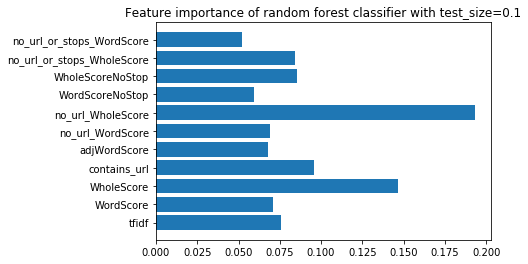

In [33]:
from sklearn.ensemble import RandomForestClassifier
#Random Forest Classifier
def random_forest_class_func(df, feature_list, target_name, test_size, estimators):
    #set up training and testing split
    X_train, X_test, y_train, y_test = set_up_train_test_split(df, feature_list, target_name, test_size)
    
    #fit ridge classifier to x and y training set
    clf = RandomForestClassifier(n_estimators = estimators).fit(X_train, y_train)
    
    return clf
    
#     importances = clf.feature_importances_
    
#     #Predict with ridge classifier on x and y testing set
#     y_val = clf.predict(X_test)
    
#     #report the correct percentage of predictions
#     percentage = determine_accuracy(y_test, y_val)
    
#     #Send data to csv to keep track of data
#     data = [[feature_list, test_size, percentage, estimators]]
#     return_df = pd.DataFrame(data, columns = ['features', 'test size', 'percent correct', 'n_estimators'])
#     return_df.to_csv('files/ML_Results/RandomForestClassifier_Results.csv', mode='a', header=False, index=False)
    
#     print('Percentage correct: ' + str(percentage) + '\n')
#     plt.barh(feature_list, importances)
#     plt.title('Feature importance of random forest classifier with test_size=' + str(test_size))

features = ['tfidf', 'WordScore', 'WholeScore', 'contains_url', 'adjWordScore', 'no_url_WordScore', 'no_url_WholeScore', 'WordScoreNoStop', 'WholeScoreNoStop', 'no_url_or_stops_WholeScore', 'no_url_or_stops_WordScore']
our_model = random_forest_class_func(comments_df, features, 'action', 0.1, 1000)

Now, we need to take in the comment and article we want to predict on and acquire all features for the comment. This will be the order in which we collect features:
 - contains url feature
 - tfidf
 - WordScore
 - WholeScore
 - adjWordScore
 - no_url_WordScore
 - no_url_WholeScore
 - WordScoreNoStop
 - WholeScoreNoStop
 - no_url_or_stops_WordScore
 - no_url_or_stops_WholeScore

In [35]:
comment = 'this is a comment'
features = ['WordScore', 'WholeScore', 'contains_url', 'adjWordScore', 'no_url_WordScore', 'no_url_WholeScore', 'WordScoreNoStop', 'WholeScoreNoStop', 'no_url_or_stops_WordScore', 'no_url_or_stops_WholeScore']

import re
import string

def contains_url_feature(comment):
    urlarr = []
    urlarr = re.findall('[(]?http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(com['content']))
    if not urlarr:
        return False
    else:
        return True

In [36]:
def tfidf_feature(comment, article):
    return

In [39]:
import spacy
from spacy import displacy
from collections import Counter

import en_core_web_lg
nlp = en_core_web_lg.load()

from spacy_wordnet.wordnet_annotator import WordnetAnnotator
nlp.add_pipe(WordnetAnnotator(nlp.lang), after='tagger')

def wordscore_feature(comment, article):
    return